In [1]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Importing plotly failed. Interactive plots will not work.


In [2]:
# Источник данных:
data_link = r'https://ir.aeroflot.ru/fileadmin/user_upload/files/eng/companys_reporting/Operating_highlights/2020/traffic_figures_07_2020_eng.xls'
data = pd.read_excel(data_link, header=1)

In [3]:
# Количество строк и столбцов:
data.shape

(168, 83)

In [4]:
# Верхняя часть таблицы - ежемесячный трафик в абсолютном выражении:
data = data.head(39)
data

,Unnamed: 0,Unnamed: 1,Main operating indicators,Unnamed: 3,January 2014,February 2014,March \n2014,April \n2014,May\n2014,June 2014,...,October\n2019,November\n2019,December\n2019,January 2020,February 2020,March 2020,April \n2020,May \n2020,June \n2020,July\n2020
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1.,Revenue Passenger Kilometers,million RPK,6180.5,5649.9,6528.1,6622.3,7340.8,8605.8,...,13294.8,11395.6,11294.6,11238.3,10246.2,7550.83,558.722,730.182,2391.73,5970.45
3,NaN,NaN,incl. International,"-""-",4179.9,3528.8,4169.6,4151.2,4514.2,5243.2,...,7878.07,6719.01,6594.54,6851.91,6077.73,3651.31,56.1817,89.8725,117.408,109.839
4,NaN,NaN,Domestic,"-""-",2000.6,2121.1,2358.5,2471.1,2826.6,3362.6,...,5416.73,4676.61,4700.08,4386.43,4168.51,3899.52,502.54,640.309,2274.32,5860.61
5,NaN,2.,Revenue Tonne Kilometers,million RTK,603,555.6,656.3,653.8,714.2,826.5,...,1317.25,1151.09,1141.32,1107.68,1030.16,782.18,97.7289,141.176,274.59,608.697
6,NaN,NaN,incl. International,"-""-",404.3,345.2,416.6,406.8,434.9,499.9,...,780.642,684.054,667.764,679.93,615.42,387.606,23.8911,54.855,27.0059,29.0073
7,NaN,NaN,Domestic,"-""-",198.7,210.4,239.7,246.9,279.3,326.6,...,536.607,467.031,473.553,427.746,414.736,394.574,73.8378,86.3209,247.584,579.69
8,NaN,3.,Passengers carried,thousands,2256.3,2157.5,2480.9,2541.8,2858.4,3370.8,...,5201.22,4416.27,4372.91,4234.4,3944.25,3017.33,228.951,305.598,1196.62,2919.91
9,NaN,NaN,incl. International,"-""-",1248,1054.4,1258.6,1258.4,1429.7,1699,...,2379.94,1911.87,1868.89,1876.14,1691.8,946.529,9.924,15.624,26.557,27.72


In [5]:
# Убираем пустые строки и столбцы:
data = data.loc[2:, 'Main operating indicators':]

In [6]:
# Выбираем строку с данными по пассажироперевозкам:
pass_data = data[data['Main operating indicators'] == 'Passengers carried'].copy()

In [7]:
pass_data

,Main operating indicators,Unnamed: 3,January 2014,February 2014,March \n2014,April \n2014,May\n2014,June 2014,July\n 2014,August\n 2014,...,October\n2019,November\n2019,December\n2019,January 2020,February 2020,March 2020,April \n2020,May \n2020,June \n2020,July\n2020
8,Passengers carried,thousands,2256.3,2157.5,2480.9,2541.8,2858.4,3370.8,3797.2,3771.6,...,5201.22,4416.27,4372.91,4234.4,3944.25,3017.33,228.951,305.598,1196.62,2919.91


In [8]:
# Убираем столбец с ед. изм.:
pass_data.drop('Unnamed: 3', axis='columns', inplace=True)

In [9]:
# Заменяем перенос строки в названиях столбцов пробелом:
pass_data.columns = pass_data.columns.str.replace('\n', ' ')

In [10]:
# Преобразуем таблицу в вертикальный формат:
pass_data = pd.melt(pass_data, id_vars=['Main operating indicators'], var_name='Period', value_name='Passengers_K')

In [11]:
pass_data.head()

,Main operating indicators,Period,Passengers_K
0,Passengers carried,January 2014,2256.3
1,Passengers carried,February 2014,2157.5
2,Passengers carried,March 2014,2480.9
3,Passengers carried,April 2014,2541.8
4,Passengers carried,May 2014,2858.4


In [12]:
# Преобразуем периоды в формат datetime с ежемесячной частотой:
pass_data['Period'] = pd.date_range(start='2014-01-01', periods=len(pass_data), freq='M')

In [13]:
pass_data.head()

,Main operating indicators,Period,Passengers_K
0,Passengers carried,2014-01-31,2256.3
1,Passengers carried,2014-02-28,2157.5
2,Passengers carried,2014-03-31,2480.9
3,Passengers carried,2014-04-30,2541.8
4,Passengers carried,2014-05-31,2858.4


In [14]:
# Убираем лишние столбцы:
pass_data.drop('Main operating indicators', axis='columns', inplace=True)

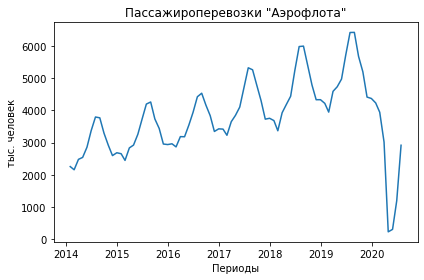

In [15]:
# График с динамикой пассажироперевозок:
plt.plot(pass_data['Period'], pass_data['Passengers_K'])
plt.title('Пассажироперевозки "Аэрофлота"')
plt.xlabel('Периоды')
plt.ylabel('тыс. человек')
plt.tight_layout()

In [16]:
# Переименовываем столбцы в соответствии с форматом модели Prophet:
pass_data.columns = ['ds', 'y']

In [17]:
pass_data.head()

,ds,y
0,2014-01-31,2256.3
1,2014-02-28,2157.5
2,2014-03-31,2480.9
3,2014-04-30,2541.8
4,2014-05-31,2858.4


In [18]:
# Инициализация и обучение модели:
model = Prophet(seasonality_mode='multiplicative', mcmc_samples=300)
model.fit(pass_data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# Создание временной шкалы для прогнозируемого периода:
future = model.make_future_dataframe(periods=12, freq='M')

In [20]:
# Прогноз на 12 месяцев вперед:
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))

           ds         yhat   yhat_lower   yhat_upper
79 2020-08-31  6002.872452  4340.343884  7777.050640
80 2020-09-30  4788.337522  3269.126715  6347.654201
81 2020-10-31  4041.885106  2538.326311  5564.623215
82 2020-11-30  2974.032695  1430.529353  4583.973923
83 2020-12-31  3311.008632  1894.518039  4818.728585
84 2021-01-31  3754.236093  2265.108119  5184.352825
85 2021-02-28  3265.711353  1916.465336  4694.053786
86 2021-03-31  3503.427989  2160.180000  4893.031472
87 2021-04-30  2921.512701  1567.442696  4177.559007
88 2021-05-31  3269.584522  1893.176646  4641.543232
89 2021-06-30  3796.735504  2399.811475  5215.096496
90 2021-07-31  4576.146061  3037.548032  6042.946156


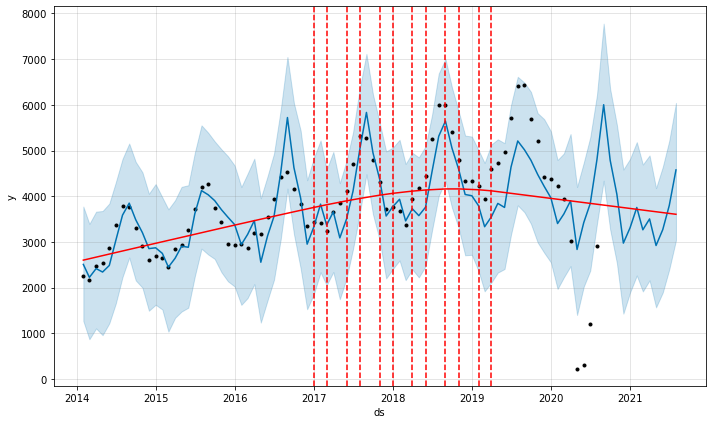

In [21]:
# Визуализация прогноза:
fig1 = model.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), model, forecast)

C:\ProgramData\Anaconda3\envs\Jup_P37\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


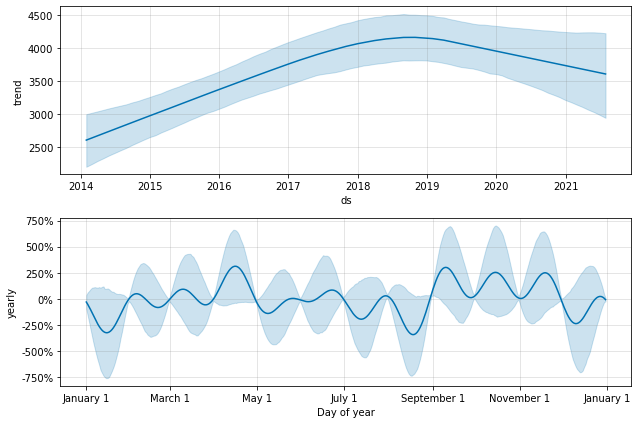

In [22]:
# Разложение временного ряда на компоненты:
fig2 = model.plot_components(forecast)